In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import glob
import scipy.misc
import math
import random
import os
import imageio
import cv2

In [55]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

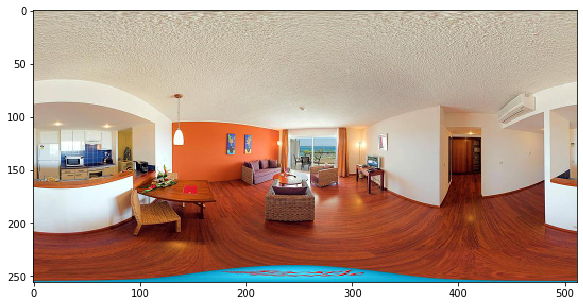

In [36]:
# Load image
img_path = "/home/clara/Workspace/EquiConvs/"
img_name = "pano_abqcqnlcixhhbq.jpg"
img = Image.open(img_path+img_name)
img = np.array(img)

# Reduce scale and show image
scale = 2
img = cv2.resize(img, dsize=(int(img.shape[1]/scale),int(img.shape[0]/scale)), interpolation=cv2.INTER_CUBIC)
plt.rcParams['figure.figsize'] = [10, 5]
plt.imshow(img)
        
pano_H = img.shape[0]
pano_W = img.shape[1]

### Spherical parametrization of EquiConvs: 

Unlike standard kernels, that are parameterized by their size $k_w \times k_h$, with EquiConvs we define the angular size $\alpha_w \times \alpha_h$ and resolution $r_w \times r_h$. 

In CFL, we use the same kernel resolutions and field of views as in ResNet-50. This means that for a standard 3$\times$3 kernel applied to a W$\times$H feature map:

$r_w = r_h = 3$, 

$\alpha_w = r_w \frac{fov_w}{W}$, where $fov_w=360^\circ$ for panoramas,

and $\alpha_h = r_h \frac{fov_h}{H}$, where $fov_h=180^\circ$ for panoramas.

We can also add an alpha multiplier (dilation rate) to have a bigger field of view as with Atrous Convolutions.

In [40]:
# Kernel parameters
r_w = 5
r_h = 5

alpha_multiplier = 8
a_w = r_w*(2*math.pi)/pano_W * alpha_multiplier
a_h = r_h*(math.pi)/pano_H * alpha_multiplier

# Distance from the center of the sphere to the kernel grid
d = r_w / (2*np.tan(a_w/2))
c_x = 0
c_y = 0
K = np.array([[d,0,c_x],[0,d,c_y],[0,0,1]])
inv_K = np.linalg.inv(K)

# Step
step = 64

# Kernel grid
h_range = np.array(range(r_h))
w_range = np.array(range(r_w))
h_ones = np.ones(r_h)
w_ones = np.ones(r_w)
h_grid = np.matmul(np.expand_dims(h_range,-1),np.expand_dims(w_ones,0))+0.5-float(r_h)/2
w_grid = np.matmul(np.expand_dims(h_ones,-1),np.expand_dims(w_range,0))+0.5-float(r_w)/2

We generate offsets that are not learned (as in original deformable convolutions) but fixed given the spherical distortion model and constant over the same horizontal locations.

$u_{0,0},v_{0,0}$: pixel location on the equirectangular image where we apply the convolution operation, i.e. the image coordinate where the center of the kernel is located). You can play in the code below and visualize the kernel at different positions to visualize the different distortions, it's specially interesting to see what happens on the poles (upper and bottom part of the image) and in the borders (left and right sides).

${\color{cPhi}\phi_{0,0}}$, ${\color{cTheta}\theta_{0,0}}$: corresponding spherical angles of the center of the kernel

In [51]:
# Choose location on the equirectangular image to visualize the kernel
u_00 = 40 
v_00 = 30 

phi_00 = (u_00-pano_W/2)*2*math.pi/pano_W
theta_00 = -(v_00-pano_H/2)*math.pi/pano_H

# Rotation to move kernel coordinates to the corresponding position on the sphere
R_y = rotation_matrix([0,1,0],phi_00)
R_x = rotation_matrix([1,0,0],theta_00)
R = np.matmul(R_y,R_x)

# Create the 3D rays for each element in the kernel grid
rays = np.stack([w_grid,h_grid,np.ones(h_grid.shape)],0)
rays = np.matmul(inv_K,rays.reshape(3,r_h*r_w))
rays /= np.linalg.norm(rays,axis=0,keepdims=True)
rays = np.matmul(R,rays)
rays= rays.reshape(3,r_h,r_w)

# Get angle coordinates for each element in the kernel and go back to pixel coordinates
phi = np.arctan2(rays[0,...],rays[2,...])
theta = np.arcsin(np.clip(rays[1,...],-1,1))
u = float(pano_W)/(2.*np.pi)*phi +float(pano_W)/2
v = float(pano_H)/(np.pi)*(theta) +float(pano_H)/2.

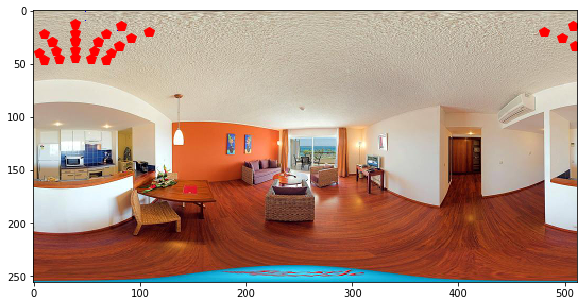

In [54]:
# Visualization
for i in range(u.shape[0]):
    for j in range(u.shape[1]):
        plt.plot(int(u[i,j]-0.5), int(v[i,j]-0.5), 'rp', markersize=10)

plt.plot(int(u_00-0.5), int(v_00-0.5), 'rp', markersize=10)
plt.rcParams['figure.figsize'] = [10, 5]
plt.imshow(img)